## About

This page showcases the work of [Cedric Scherer](https://www.cedricscherer.com), built for the [TidyTuesday](https://github.com/rfordatascience/tidytuesday) initiative. You can find the original code on his github repository [here](https://github.com/z3tt/TidyTuesday/blob/master/R/2020_03_Passwords.Rmd), written in [R](https://www.r-graph-gallery.com).

Thanks to him for accepting sharing his work here! Thanks also to [Tomás Capretto](https://tcapretto.netlify.app/) who translated this work from R to Python! 🙏🙏

## Load libraries

<!-- The first step is always to import some libraries. `NumPy` is going to be used to make some computations with arrays and `load_penguins()` is imported from the `palmerpenguins` library to have access to the popular dataset. -->

Let's load libraries and utilities that are going to be used today. [`textwrap`](https://docs.python.org/3/library/textwrap.html) is Python built-in module that contains several utilities to wrap text. In this post, it is going to help us to split long names into multiple lines.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from textwrap import wrap

## Load and prepare the data

This guide shows how to create a beautiful circular barplot to visualize several characteristics of hiking locations in Washington.

The data for this post comes from [Washington Trails Association](https://www.wta.org/go-outside/hikes?b_start:int=1) courtesy of the [TidyX crew](https://github.com/thebioengineer/TidyX/tree/master/TidyTuesday_Explained/035-Rectangles), [Ellis Hughes](https://twitter.com/Ellis_hughes) and [Patrick Ward](https://twitter.com/OSPpatrick). This guide uses the dataset released for the [TidyTuesday](https://github.com/rfordatascience/tidytuesday) initiative on the week of 2020-11-24. You can find the original announcement and more information about the data [here](https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-11-24). Thank you all for making this possible!

Let's start by loading and exploring the first rows of the dataset.

In [2]:
df_pw = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-14/passwords.csv')
df_pw = df_pw.dropna(subset=['password'])
df_pw.head()

,rank,password,category,value,time_unit,offline_crack_sec,rank_alt,strength,font_size
0,1.0,password,password-related,6.91,years,2.170000e+00,1.0,8.0,11.0
1,2.0,123456,simple-alphanumeric,18.52,minutes,1.110000e-05,2.0,4.0,8.0
2,3.0,12345678,simple-alphanumeric,1.29,days,1.110000e-03,3.0,4.0,8.0
3,4.0,1234,simple-alphanumeric,11.11,seconds,1.110000e-07,4.0,4.0,8.0
4,5.0,qwerty,simple-alphanumeric,3.72,days,3.210000e-03,5.0,8.0,11.0


In [3]:
def to_seconds(value, time_unit):
    if time_unit == "seconds":
        return value
    elif time_unit == "minutes":
        return value * 60
    elif time_unit == "hours":
        return value * 60 * 60
    elif time_unit == "days":
        return value * 60 * 27
    elif time_unit == "weeks":
        return value * 60 * 24 * 7
    elif time_unit == "months":
        return value * 60 * 24 * 30
    elif time_unit == "years":
        return value * 60 * 24 * 365
    else:
        return np.nan

In [4]:
print(to_seconds(152, "seconds"))
print(to_seconds(13.8, "hours"))

152
49680.0


In [5]:
df_pw["time"] = df_pw.apply(lambda x: to_seconds(x["value"], x["time_unit"]), axis=1)

In [6]:
plus = 1000

df_pw_plot = df_pw.copy()
df_pw_plot["time"] = df_pw_plot["time"] + plus

In [7]:
labels = df_pw_plot[df_pw_plot["value"] > 90].reset_index()
labels["label"] = [f"{pswrd}\nRank: {int(rank)}" for pswrd, rank in zip(labels["password"], labels["rank"])]
labels["x"] = [42, 332, 401, 496]
labels["y"] = [160000000, 90000000, 45000000, 48498112]
labels

,index,rank,password,category,value,time_unit,offline_crack_sec,rank_alt,strength,font_size,time,label,x,y
0,25,26.0,trustno1,simple-alphanumeric,92.27,years,29.02,26.0,25.0,20.0,48498112.0,trustno1\nRank: 26,42,160000000
1,335,336.0,rush2112,nerdy-pop,92.27,years,29.02,337.0,48.0,28.0,48498112.0,rush2112\nRank: 336,332,90000000
2,405,406.0,jordan23,sport,92.27,years,29.27,407.0,34.0,23.0,48498112.0,jordan23\nRank: 406,401,45000000
3,499,500.0,passw0rd,password-related,92.27,years,29.02,502.0,28.0,21.0,48498112.0,passw0rd\nRank: 500,496,48498112


In [8]:
# Values for the x axis
ANGLES = np.linspace(0, 2 * np.pi, len(df_pw), endpoint=False)

# Cumulative length
HEIGHTS = df_pw["time"].values

# Category values for the colors
CATEGORY_CODES = pd.Categorical(df_pw["category"]).codes

# https://carto.com/carto-colors/
COLORMAP = ["#5F4690", "#1D6996", "#38A6A5", "#0F8554", "#73AF48", 
            "#EDAD08", "#E17C05", "#CC503E", "#94346E", "#666666"]

COLORS = np.array(COLORMAP)[CATEGORY_CODES]

And we finally define a function that scales the number of votes to the size of the dot in the lollipop.

In [9]:
TIME_MAX = df_pw["time"].max()
TIME_MIN = df_pw["time"].min()

# low and high refer to the final dot size.
def scale_to_interval(x, low=0.25, high=20):
    return ((x - TIME_MIN) / (TIME_MAX - TIME_MIN)) * (high - low) + low

In [10]:
GREY88 = "#e0e0e0"
GREY85 = "#d9d9d9"
GREY82 = "#d1d1d1"
GREY79 = "#c9c9c9"
GREY97 = "#f7f7f7"
GREY60 = "#999999"

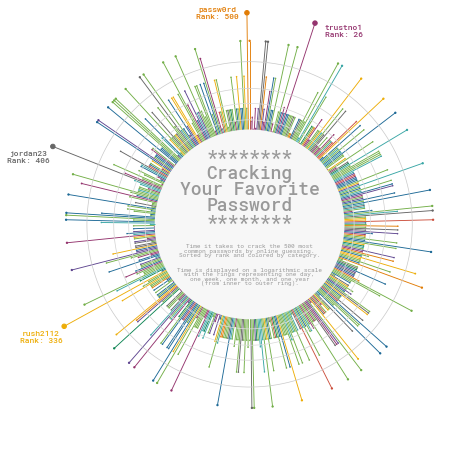

In [11]:
# Initialize layout in polar coordinates
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "polar"})

# Set background color to white, both axis and figure.
fig.patch.set_facecolor("white")
ax.set_facecolor("white")
ax.set_rscale('symlog')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1) # reverse

ax.vlines(ANGLES, 0 + plus, HEIGHTS + plus, color=COLORS, lw=0.9)
ax.scatter(ANGLES, HEIGHTS + plus, s=scale_to_interval(HEIGHTS), color=COLORS)

ax.spines["start"].set_color("none")
ax.spines["polar"].set_color("none")

ax.grid(False)
ax.set_xticks([])
ax.set_yticklabels([])


HANGLES = np.linspace(0, 2 * np.pi, 200)
ax.plot(HANGLES, np.repeat(1 * 24 * 60 + plus, 200), color= GREY88, lw=0.7)
ax.plot(HANGLES, np.repeat(7 * 24 * 60 + plus, 200), color= GREY85, lw=0.7)
ax.plot(HANGLES, np.repeat(30 * 24 * 60 + plus, 200), color= GREY82, lw=0.7)
ax.plot(HANGLES, np.repeat(365 * 24 * 60 + plus, 200), color= GREY79, lw=0.7)


# Now fill the area of the circle with radius 1.
# This create the effect of gray background.
ax.fill(HANGLES, np.repeat(plus, 200), GREY97)


for idx, row in labels.iterrows():
    color = COLORS[row["index"]]
    ax.text(
        ANGLES[row["x"]], 
        row["y"], 
        row["label"],
        ha="right",
        va="center",
        ma="center",
        size=8,
        family="Roboto Mono",
        weight="bold",
        color=color
    )

ax.text(
    x=0.5,
    y=0.58,
    s="********\nCracking\nYour Favorite\nPassword\n********",
    color=GREY60,
    va="center",
    ha="center",
    ma="center",
    fontfamily="Roboto Mono",
    fontsize=18,
    fontweight="bold",
    linespacing=0.87,
    transform=ax.transAxes
)

ax.text(
    x=0.5,
    y=0.44,
    s="Time it takes to crack the 500 most\ncommon passwords by online guessing.\nSorted by rank and colored by category.",
    color=GREY60,
    va="center",
    ha="center",
    ma="center",
    fontfamily="Roboto Mono",
    fontsize=6,
    linespacing=0.87,
    transform=ax.transAxes
)

ax.text(
    x=0.5,
    y=0.38,
    s="Time is displayed on a logarithmic scale\nwith the rings representing one day,\none week, one month, and one year\n(from inner to outer ring).",
    color=GREY60,
    va="center",
    ha="center",
    ma="center",
    fontfamily="Roboto Mono",
    fontsize=6,
    linespacing=0.87,
    transform=ax.transAxes
)

fig.savefig("plot.png", dpi=300)

## Basic radar plot

Radar charts plot data points in a circular layout. Instead of horizontal and vertical axes, it has an **angular** and a **radial** axis for **x** and **y**, respectively. In this world, **x** values are given by **angles** and **y** values are a **distance** from the center of the circle.

In the chart we're just about to build, the **x** axis will represent the **regions**, and the **y** axis will represent their **cumulative length** and **mean gain**. Color is going to represent the **number of tracks**. Before getting started, just note the values of **x**, given in angles, have to be manually calculated and passed to Matplotlib. This is what is going on in the `np.linspace()` that defines the `ANGLES` variable.

In [12]:
# # Bars are sorted by the cumulative track length
# df_sorted = summary_all.sort_values("sum_length", ascending=False)

# # Values for the x axis
# ANGLES = np.linspace(0.05, 2 * np.pi - 0.05, len(df_sorted), endpoint=False)

# # Cumulative length
# LENGTHS = df_sorted["sum_length"].values

# # Mean gain length
# MEAN_GAIN = df_sorted["mean_gain"].values

# # Region label
# REGION = df_sorted["region"].values

# # Number of tracks per region
# TRACKS_N = df_sorted["n"].values

As usually, colors and other important values are declared before the code that actually produces the plot. In addition, the following chunk also sets the default font to **Bell MT**. For a step-by-step guide on how to install and load custom fonts in Matplotlib, have a look a [this post](https://www.python-graph-gallery.com/custom-fonts-in-matplotlib).

In [13]:
# GREY12 = "#1f1f1f"

# # Set default font to Bell MT
# plt.rcParams.update({"font.family": "Bell MT"})

# # Set default font color to GREY12
# plt.rcParams["text.color"] = GREY12

# # The minus glyph is not available in Bell MT
# # This disables it, and uses a hyphen
# plt.rc("axes", unicode_minus=False)

# # Colors
# COLORS = ["#6C5B7B","#C06C84","#F67280","#F8B195"]

# # Colormap
# cmap = mpl.colors.LinearSegmentedColormap.from_list("my color", COLORS, N=256)

# # Normalizer
# norm = mpl.colors.Normalize(vmin=TRACKS_N.min(), vmax=TRACKS_N.max())

# # Normalized colors. Each number of tracks is mapped to a color in the 
# # color scale 'cmap'
# COLORS = cmap(norm(TRACKS_N))

Excited about how to make it? Let's do it!

In [14]:
# # Some layout stuff ----------------------------------------------
# # Initialize layout in polar coordinates
# fig, ax = plt.subplots(figsize=(9, 12.6), subplot_kw={"projection": "polar"})

# # Set background color to white, both axis and figure.
# fig.patch.set_facecolor("white")
# ax.set_facecolor("white")

# ax.set_theta_offset(1.2 * np.pi / 2)
# ax.set_ylim(-1500, 3500)

# # Add geometries to the plot -------------------------------------
# # See the zorder to manipulate which geometries are on top

# # Add bars to represent the cumulative track lengths
# ax.bar(ANGLES, LENGTHS, color=COLORS, alpha=0.9, width=0.52, zorder=10)

# # Add dashed vertical lines. These are just references
# ax.vlines(ANGLES, 0, 3000, color=GREY12, ls=(0, (4, 4)), zorder=11)

# # Add dots to represent the mean gain
# ax.scatter(ANGLES, MEAN_GAIN, s=60, color=GREY12, zorder=11)


# # Add labels for the regions -------------------------------------
# # Note the 'wrap()' function.
# # The '5' means we want at most 5 consecutive letters in a word, 
# # but the 'break_long_words' means we don't want to break words 
# # longer than 5 characters.
# REGION = ["\n".join(wrap(r, 5, break_long_words=False)) for r in REGION]
# REGION

# # Set the labels
# ax.set_xticks(ANGLES)
# ax.set_xticklabels(REGION, size=12);

Pretty good start! It wasn't too complicated to map the variable onto the different geometries in the plot. 

## Customize guides and annotations

The plot above looks quite nice for a start. But so many reference lines are unnecesary. Let's remove these defaults and improve this chart with custom annotations and guides.

In [15]:
# # Remove unnecesary guides ---------------------------------------

# # Remove lines for polar axis (x)
# ax.xaxis.grid(False)

# # Put grid lines for radial axis (y) at 0, 1000, 2000, and 3000
# ax.set_yticklabels([])
# ax.set_yticks([0, 1000, 2000, 3000])

# # Remove spines
# ax.spines["start"].set_color("none")
# ax.spines["polar"].set_color("none")


# # Adjust padding of the x axis labels ----------------------------
# # This is going to add extra space around the labels for the 
# # ticks of the x axis.
# XTICKS = ax.xaxis.get_major_ticks()
# for tick in XTICKS:
#     tick.set_pad(10)


# # Add custom annotations -----------------------------------------
# # The following represent the heights in the values of the y axis
# PAD = 10
# ax.text(-0.2 * np.pi / 2, 1000 + PAD, "1000", ha="center", size=12)
# ax.text(-0.2 * np.pi / 2, 2000 + PAD, "2000", ha="center", size=12)
# ax.text(-0.2 * np.pi / 2, 3000 + PAD, "3000", ha="center", size=12)


# # Add text to explain the meaning of the height of the bar and the
# # height of the dot
# ax.text(ANGLES[0], 3100, "Cummulative Length [FT]", rotation=21, 
#         ha="center", va="center", size=10, zorder=12)
# ax.text(ANGLES[0]+ 0.012, 1300, "Mean Elevation Gain\n[FASL]", rotation=-69, 
#         ha="center", va="center", size=10, zorder=12)
# fig

## Final chart

The result looks much better! The clutter in the previous plot has dissapeared, that's great! The last step is to add a legend that makes the colors more meaningful and a good title and annotations that can easily transmit what this chart is about.

In [16]:
# # Add legend -----------------------------------------------------

# # First, make some room for the legend and the caption in the bottom.
# fig.subplots_adjust(bottom=0.175)

# # Create an inset axes.
# # Width and height are given by the (0.35 and 0.01) in the 
# # bbox_to_anchor
# cbaxes = inset_axes(
#     ax, 
#     width="100%", 
#     height="100%", 
#     loc="center",
#     bbox_to_anchor=(0.325, 0.1, 0.35, 0.01),
#     bbox_transform=fig.transFigure # Note it uses the figure.
# ) 

# # Create a new norm, which is discrete
# bounds = [0, 100, 150, 200, 250, 300]
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# # Create the colorbar
# cb = fig.colorbar(
#     ScalarMappable(norm=norm, cmap=cmap), 
#     cax=cbaxes, # Use the inset_axes created above
#     orientation = "horizontal",
#     ticks=[100, 150, 200, 250]
# )

# # Remove the outline of the colorbar
# cb.outline.set_visible(False)

# # Remove tick marks
# cb.ax.xaxis.set_tick_params(size=0)

# # Set legend label and move it to the top (instead of default bottom)
# cb.set_label("Amount of tracks", size=12, labelpad=-40)

# # Add annotations ------------------------------------------------

# # Make some room for the title and subtitle above.
# fig.subplots_adjust(top=0.8)

# # Define title, subtitle, and caption
# title = "\nHiking Locations in Washington"
# subtitle = "\n".join([
#     "This Visualisation shows the cummulative length of tracks,",
#     "the amount of tracks and the mean gain in elevation per location.\n",
#     "If you are an experienced hiker, you might want to go",
#     "to the North Cascades since there are a lot of tracks,",
#     "higher elevations and total length to overcome."
# ])
# caption = "Data Visualisation by Tobias Stalder\ntobias-stalder.netlify.app\nSource: TidyX Crew (Ellis Hughes, Patrick Ward)\nLink to Data: github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-11-24/readme.md"

# # And finally, add them to the plot.
# fig.text(0.1, 0.93, title, fontsize=25, weight="bold", ha="left", va="baseline")
# fig.text(0.1, 0.9, subtitle, fontsize=14, ha="left", va="top")
# fig.text(0.5, 0.025, caption, fontsize=10, ha="center", va="baseline")

# # Note: you can use `fig.savefig("plot.png", dpi=300)` to save it with in hihg-quality.
# fig